The number of qubits represents the number of input variables
One big layer is represented by 2 sub-layers:
-  First sublayer is represented by RX,RY, and RZ. One gate of each per qubit with its respective weight(theta)
-  Second sublayer is represented by the entanglement between all the qubits

In [12]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from torch import Tensor
from qiskit.circuit import ParameterVector
import torch

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

import numpy as np

In [13]:


def one_qubit_rotation(qc, weights, gate_types_per_layer, enable_rx=True, enable_ry=True, enable_rz=True):
    """
    Adds rotation gates around the X, Y, and Z axis to the quantum circuit for a specific qubit,
    with the rotation angles specified by the values in `weights`.
    """
    if len(weights) != gate_types_per_layer * len(qc.qubits):
        print(f"len weights {len(weights)}")
        print(f"gate types per layer {gate_types_per_layer}")
        print(f"len qubits {len(qc.qubits)}")
        print(f"len qubits * gate types per layer {len(qc.qubits)*gate_types_per_layer}")
        raise ValueError("The number of weights must be equal to the number of qubits times the number of gate types per layer")
    
    if not enable_rx and not enable_ry and not enable_rz:
        raise ValueError("At least one gate must be enabled")
        
    enabled_gates = sum([enable_rx, enable_ry, enable_rz])  # Count how many gates are enabled
    if len(weights) != enabled_gates * len(qc.qubits):
        print(len(weights))
        print(enabled_gates)
        print(len(qc.qubits))
        print(len(qc.qubits)*enabled_gates)
        raise ValueError("The number of weights does not match the number of enabled gates times the number of qubits")
    
    for qubit in qc.qubits:
        index = qubit.index
        weight_index = 0  # Initialize weight index for each qubit
        
        if enable_rx:
            qc.rx(weights[index + weight_index * len(qc.qubits)], index)  # Rotate around X-axis
            weight_index += 1  # Move to the next set of weights
            
        if enable_ry:
            qc.ry(weights[index + weight_index * len(qc.qubits)], index)  # Rotate around Y-axis
            weight_index += 1  # Move to the next set of weights
            
        if enable_rz:
            qc.rz(weights[index + weight_index * len(qc.qubits)], index)  # Rotate around Z-axis
            # No need to increase weight_index here since it's the last operation


def entangling_layer(qc:QuantumCircuit):
    """
    Adds a layer of CZ entangling gates (controlled-Z) on `qubits` (arranged in a circular topology) to the quantum circuit.
    """
    # Assume `qc` is your QuantumCircuit object that's defined outside this function
    for i in range(qc.num_qubits - 1):
        qc.cz(i, i+1)  # Apply CZ between consecutive qubits
    if qc.num_qubits > 2:  # If more than 2 qubits, connect the first and last qubits to form a circle
        qc.cz(0, qc.num_qubits-1)


In [14]:


def generate_circuit(qc, n_layers, enable_rx=True, enable_ry=True, enable_rz=True):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits=qc.num_qubits
    # if gate is enabled, add a parameter for each qubit and for each layer
    
    gate_types_per_layer= 0
    if enable_rx:
        gate_types_per_layer+=1
    if enable_ry:
        gate_types_per_layer+=1
    if enable_rz:
        gate_types_per_layer+=1
    if gate_types_per_layer==0:
        raise ValueError("At least one gate must be enabled")
    if n_layers<1:
        raise ValueError("At least one layer is required")
    if n_qubits<1:
        raise ValueError("At least one qubit is required")

    
    params = ParameterVector("theta", gate_types_per_layer*(n_layers+1)*n_qubits)
    inputs= ParameterVector("inputs", n_qubits)
    
    for i in range(n_layers):
        for j in range(n_qubits):
            qc.rx(inputs[j], j)
        qc.barrier()
        # Variational layer
        if i == 0:
            one_qubit_rotation(qc, params[0:gate_types_per_layer*n_qubits],gate_types_per_layer=gate_types_per_layer, enable_rx=enable_rx,enable_ry=enable_ry,enable_rz=enable_rz)
        else:
            one_qubit_rotation(qc, params[i*gate_types_per_layer*n_qubits:(i+1)*gate_types_per_layer*n_qubits],gate_types_per_layer=gate_types_per_layer, enable_rx=enable_rx,enable_ry=enable_ry,enable_rz=enable_rz)
        qc.barrier()
        entangling_layer(qc)
        # Encoding layer
        qc.barrier()
 
    for i in range(n_qubits):
        qc.rx(inputs[i], i)
    one_qubit_rotation(qc, params[n_layers*gate_types_per_layer*n_qubits:(n_layers+1)*gate_types_per_layer*n_qubits], gate_types_per_layer=gate_types_per_layer, enable_rx=enable_rx,enable_ry=enable_ry,enable_rz=enable_rz)

    return qc, list(params), list(inputs)

/tmp/ipykernel_46611/285491456.py:25: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed in the Qiskit 1.0 release. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  index = qubit.index


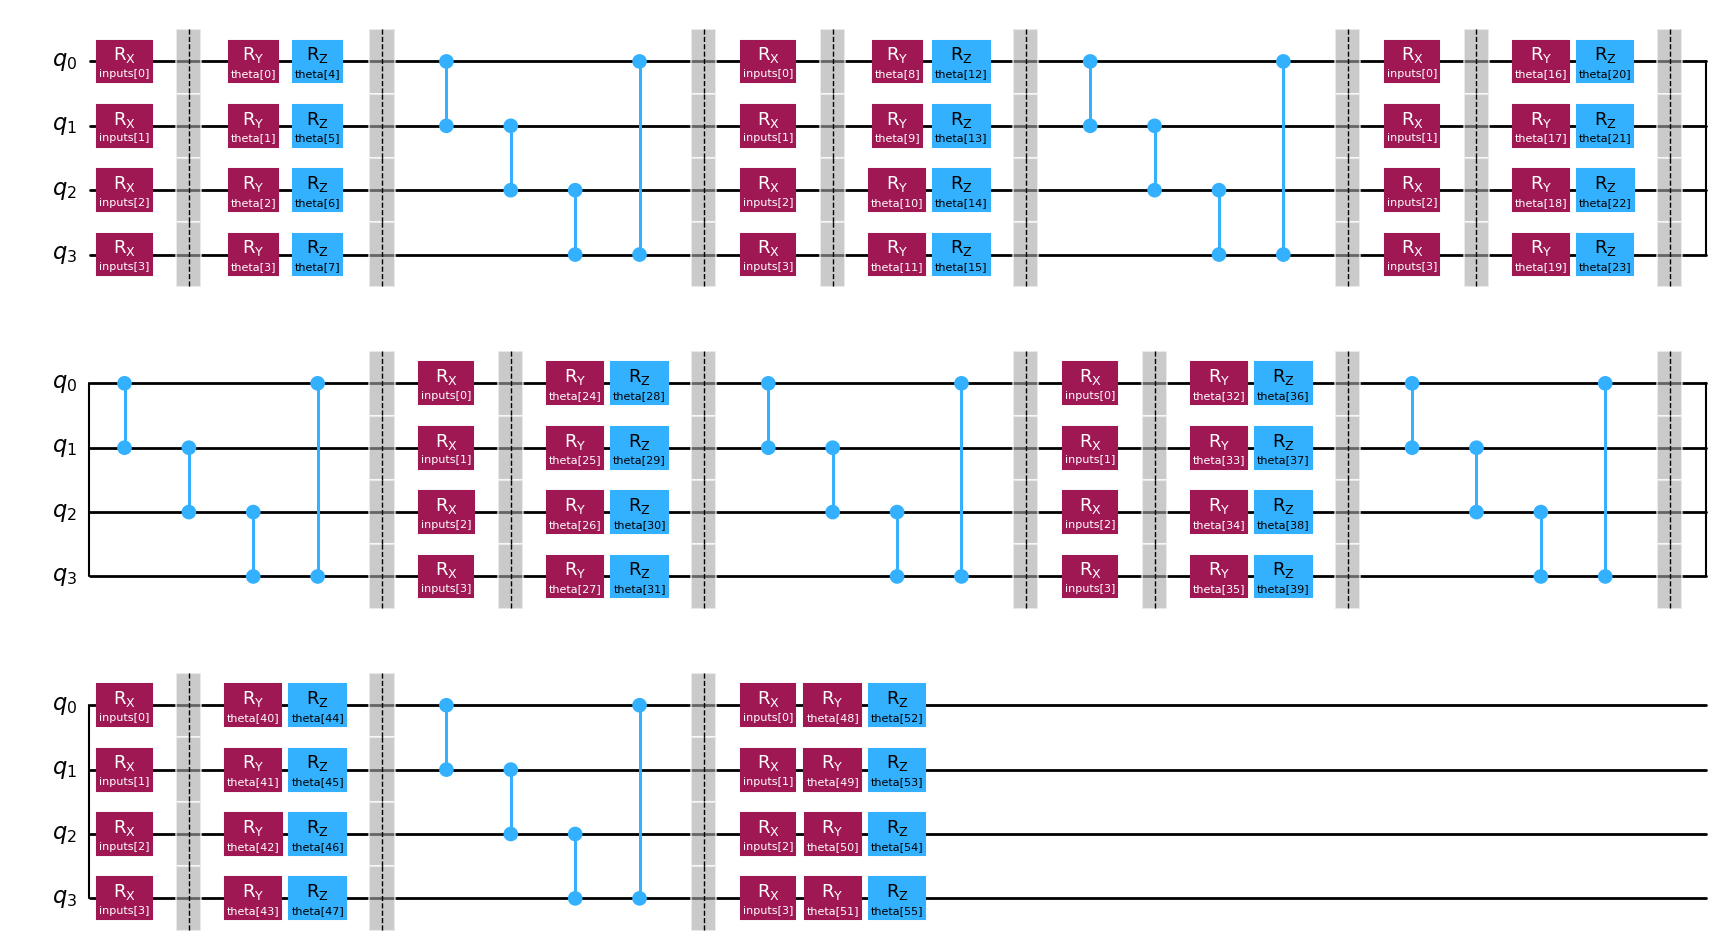

In [15]:
qc = QuantumCircuit(4)
circuit, params, inputs = generate_circuit(qc, 6,enable_rx=False, enable_ry=True, enable_rz=True)
circuit.draw("mpl", style="iqx")

In [16]:

sampler_qnn=EstimatorQNN(circuit=circuit, input_params=inputs, weight_params=params)

In [17]:

qnn=TorchConnector(sampler_qnn)

In [18]:

class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits = 4):
        super().__init__()
        
        # Define weights for the layer
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1) # <--  Initialization strategy
    
        
    def forward(self, x):
        """Forward step, as explained above."""
        
        if not isinstance(x, Tensor):
            x = Tensor(x)
        
        x = self.weights * x
        x = torch.atan(x)
                
        return x


In [19]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40) # <-- Initialization strategy (heuristic choice)
        
        # Masks that map the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)
        
    def forward(self, x):
        """Forward step, as described above."""

        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x
        
        # Single sample
        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        
        # Batch of samples
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12, dim = 1, keepdim = True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34, dim = 1, keepdim = True)
            out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1.) / 2.)

In [20]:
qnn.state_dict()

OrderedDict([('weight',
              tensor([ 0.7645,  0.8300, -0.2343,  0.9186, -0.2191,  0.2018, -0.4869,  0.5873,
                       0.8815, -0.7336,  0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,
                       0.7709,  0.1478, -0.4668,  0.2549, -0.4607, -0.1173, -0.4062,  0.6634,
                      -0.7894, -0.4610, -0.2824, -0.6013,  0.0944, -0.9877,  0.9031, -0.8495,
                       0.7720,  0.1664, -0.3247,  0.6179,  0.1559,  0.8080,  0.1093, -0.3154,
                       0.2687, -0.2712,  0.4209,  0.8928,  0.5781, -0.4372,  0.5773,  0.1789,
                       0.5078, -0.6095, -0.9899, -0.3864, -0.7670,  0.8205,  0.2880,  0.4142])),
             ('_weights',
              tensor([ 0.7645,  0.8300, -0.2343,  0.9186, -0.2191,  0.2018, -0.4869,  0.5873,
                       0.8815, -0.7336,  0.8692,  0.1872,  0.7388,  0.1354,  0.4822, -0.1412,
                       0.7709,  0.1478, -0.4668,  0.2549, -0.4607, -0.1173, -0.4062,  0.6634,
       

In [29]:
import torch
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit import QuantumCircuit

qt=QuantumCircuit(1)
qt.rx(0.5,0)
est=EstimatorQNN(circuit=qt, input_params=[], weight_params=[])
print(est.weight_params)
qtest=TorchConnector(est)
test=torch.nn.Sequential(qtest)
test.state_dict()

[]


OrderedDict([('0.weight', tensor([])), ('0._weights', tensor([]))])

In [21]:
# Classical trainable preprocessing
encoding = encoding_layer(num_qubits=4)

# Classical trainable postprocessing
exp_val = exp_val_layer()

# Stack the classical and quantum layers together 
model = torch.nn.Sequential(encoding,qnn,exp_val)

model.state_dict()

OrderedDict([('0.weights', tensor([ 0.2551,  0.7459, -0.7083,  0.4851])),
             ('1.weight',
              tensor([ 0.5033, -0.1861,  0.8569, -0.8668,  0.3048, -0.9024, -0.1391, -0.0303,
                      -0.2708,  0.0150, -0.8074, -0.9219, -0.7061,  0.4059,  0.4789, -0.9623,
                       0.6940,  0.4131, -0.3568, -0.5003, -0.5368, -0.5008,  0.7079,  0.3731,
                       0.7355, -0.3745, -0.1260, -0.6211,  0.3848,  0.0544,  0.0350,  0.4566,
                       0.3541, -0.3613,  0.6603,  0.9427,  0.2244,  0.7690, -0.7261,  0.9250,
                       0.1289,  0.0517, -0.5635,  0.9459, -0.6802,  0.1777, -0.2375,  0.3116,
                       0.0497, -0.1978, -0.4624, -0.1009,  0.9022, -0.3126,  0.0464,  0.8360])),
             ('1._weights',
              tensor([ 0.5033, -0.1861,  0.8569, -0.8668,  0.3048, -0.9024, -0.1391, -0.0303,
                      -0.2708,  0.0150, -0.8074, -0.9219, -0.7061,  0.4059,  0.4789, -0.9623,
                       

In [22]:
model(torch.tensor([0.5, 0.5, 0.5, 0.5]))

tensor([12.3579, 11.9357], grad_fn=<MulBackward0>)

In [23]:
import gymnasium as gym
env = gym.make("CartPole-v1")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

In [24]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [26]:
def epsilon_greedy_policy(state, epsilon=0):
    """Manages the transition from the *exploration* to *exploitation* phase"""
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            if isinstance(state, tuple):
                state = state[0]  # Assuming the first element of the tuple is the state array
            
            # Check if state is an instance of np.ndarray, convert it to a list if it is
            if isinstance(state, np.ndarray):
                state = state.tolist()
            Q_values = model(Tensor(state)).numpy()
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    """Sample some past experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    """Perform one action in the environment and register the state of the system"""
    action = epsilon_greedy_policy(state, epsilon)
    # next_state, r, terminated, truncated, info = self.env.step(action)

    next_state, reward, done,truncated, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def sequential_training_step(batch_size):
    """
    Actual training routine. Implements the Deep Q-Learning algorithm.
    
    This implementation evaluates individual losses sequentially instead of using batches. 
    This is due to an issue in the TorchConnector, which yields vanishing gradients if it 
    is called with a batch of data (see https://github.com/Qiskit/qiskit-machine-learning/issues/100).
    
    Use this training for the quantum model. If using the classical model, you can use indifferently 
    this implementation or the batched one below. 
    """
    
    # Sample past experiences 
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    
    # Accumulate Loss sequentially (if batching data, gradients of the parameters are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        if isinstance(state, tuple):
            state = state[0]  # Assuming the first element of the tuple is the state array
            
        # Check if state is an instance of np.ndarray, convert it to a list if it is
        if isinstance(state, np.ndarray):
            state = state.tolist()
        
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value)**2
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [27]:
from torch.optim import Adam

batch_size = 16
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=0.01)

In [28]:
rewards = [] 
best_score = 0

# We let the agent train for 2000 episodes
n_episodes = 500
for episode in range(500):
    
    # Run enviroment simulation
    obs = env.reset()  
    
    # 200 is the target score for considering the environment solved
    for step in range(200):
        
        # Manages the transition from exploration to exploitation
        epsilon = max(1 - episode / 900, 0.01)
        if isinstance(obs, tuple):
            obs = obs[0]  # Assuming the first element of the tuple is the state array
            
        # Check if state is an instance of np.ndarray, convert it to a list if it is
        if isinstance(obs, np.ndarray):
            obs = obs.tolist()
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    
    # Saving best agent
    if step >= best_score:
        # torch.save(model.state_dict(), './new_model_best_weights.pth') # Save best weights
        best_score = step
        
    print("\rEpisode: {}, Steps : {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    
    # Start training only after some exploration experiences  
    if episode > 32:
        sequential_training_step(batch_size)

Episode: 159, Steps : 17, eps: 0.823

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# This file contains the sum of rewards from a previous successfull training run
rewards_history = np.loadtxt("training_rewards2.txt") + 1

cmap = plt.get_cmap('tab20c')

fig = plt.figure(figsize=(8,5))
plt.axhline([200], ls = 'dashed', c=cmap(9))
plt.text(-50,190, s='Max reward', c=cmap(8))

plt.text(-50,100, s='Exploration\nphase', c=cmap(12))
plt.text(1100,100, s='Exploitation\nphase', c=cmap(12))

plt.plot(rewards_history, c = cmap(4))
plt.xlabel("Episodes")
plt.ylabel("Final reward")

plt.tight_layout()
plt.show()